<a href="https://colab.research.google.com/github/param-walia/Tensorflow-usage/blob/master/CIFAR_10_CNN_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
import time
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pickle

In [2]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


# Data Pre-processing

In [0]:
#Loading in data
from keras.datasets import cifar10

In [0]:
#Train-test split
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [22]:
x_train.dtype

dtype('uint8')

In [0]:
#Converting to floats
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [15]:
#The original pixel values are from 0 to 255
print(x_train.max(),x_train.min())

255.0 0.0


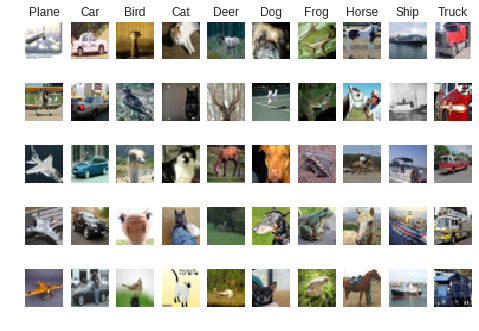

In [27]:
# Visualize some examples from the dataset.
# A few examples of training images from each class.

classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
num_classes = len(classes)
samples_per_class = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [0]:
#Normalizing the data
mean = np.mean(x_train)
std = np.std(x_train)
x_train = (x_train-mean)/std
x_test = (x_test-mean)/std

In [29]:
print(x_train.max(),x_train.min())

2.0934134 -1.8816435


In [0]:
#number of classes in CIFAR-10
num_classes = 10

#Convert to One-hot encoding
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

In [31]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

## Image Augmentation

In [0]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    )
datagen.fit(x_train)

Original images:


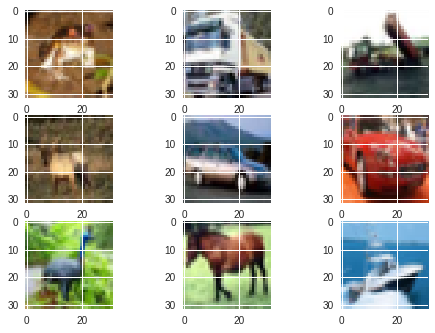

Augmented images:


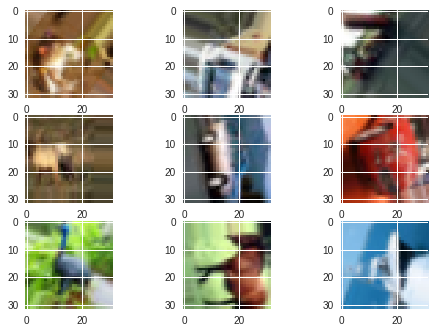

In [36]:
from matplotlib import pyplot as plt
from scipy.misc import toimage
img_rows, img_cols = 32, 32

print('Original images:')
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(toimage(x_train[i].reshape(img_rows, img_cols, 3)))
plt.show()
print('Augmented images:')
for X_batch, y_batch in datagen.flow(x_train[0:9], 
                                     y_train[0:9], 
                                     batch_size=9,
                                     shuffle=False):
    for i in range(0, 9):
        plt.subplot(330 + 1 +i)
        plt.imshow(toimage(X_batch[i].reshape(img_rows, img_cols, 3)))
    plt.show()
    break

# Model Building
We will first start with a basic 2 hidden layer CNN model and later add Batch normalization and Dropout layers. We will also play with the learning rate scheduler through Keras's callbacks.

#### Defining Class for plotting LIVE Loss and accuracies as a function of epochs

In [0]:
#@title 
#A simple method for plotting LIVE loss and accuracy as a function of epoch
#Courtesy Piotr Migdał and Kavanaugh Latiolais
#https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="train")
        ax1.plot(self.x, self.val_losses, label="validation")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="train")
        ax2.plot(self.x, self.val_acc, label="validation")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

### A basic two layer CNN

Why Conv2D(64, (3,3) ?

In [48]:
#Our first basic model with Convolution and Pooling layers
# _mp stands for Max-Pooling
model_mp = Sequential()

model_mp.add(Conv2D(64, (3,3), padding='same', input_shape=x_train.shape[1:]))
model_mp.add(Activation('relu'))
model_mp.add(MaxPooling2D(pool_size=(2,2)))

model_mp.add(Conv2D(64, (3,3), padding='same'))
model_mp.add(Activation('relu'))
model_mp.add(MaxPooling2D(pool_size=(2,2)))
     
model_mp.add(Flatten())
model_mp.add(Dense(num_classes, activation='softmax'))
 
model_mp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
activation_8 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 4096)              0         
__________

In [0]:
#training
# lr: initial Learning rate
# decay: float >= 0. Learning rate decay over each update.
# I have set decay to zero for now, we will experiment with this later
batch_size = 64
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=0)
model_mp.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

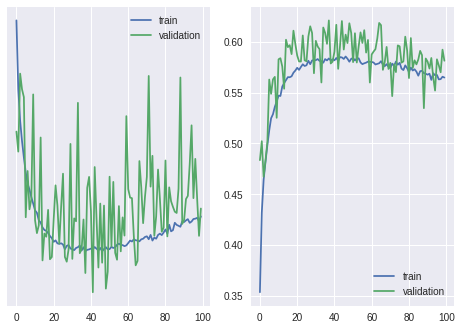

time taken:  3258.82475066185


In [50]:
start = time.time()
history_mp = model_mp.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=100,
                    verbose=1,
                    validation_data=(x_test,y_test),
                    callbacks=[plot])
end = time.time()
print('time taken: ',end-start)

In [0]:
model_mp.save('CIFAR-10_2layer_CNN.h5')

In [0]:
with open('CIFAR-10_2layer_CNN-history', 'wb') as file_pi:
  pickle.dump(history_mp.history, file_pi, protocol=pickle.HIGHEST_PROTOCOL)


1.  Why does loss start increasing?
2.   Why is validaton loss and accuracy fluctuating?




### Check for the random initializer
Re-running for the same architecture to check how much the performance can change

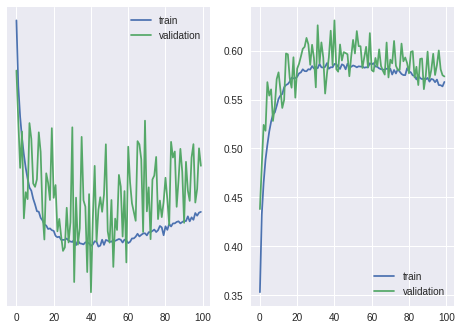

time taken:  3272.805460214615


In [52]:

model_mp2 = Sequential()

model_mp2.add(Conv2D(64, (3,3), padding='same', input_shape=x_train.shape[1:]))
model_mp2.add(Activation('relu'))
model_mp2.add(MaxPooling2D(pool_size=(2,2)))

model_mp2.add(Conv2D(64, (3,3), padding='same'))
model_mp2.add(Activation('relu'))
model_mp2.add(MaxPooling2D(pool_size=(2,2)))
     
model_mp2.add(Flatten())
model_mp2.add(Dense(num_classes, activation='softmax'))
 

batch_size = 64
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=0)
model_mp2.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

start = time.time()
history_mp2 = model_mp2.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=100,
                    verbose=1,
                    validation_data=(x_test,y_test),
                    callbacks=[plot])
end = time.time()
print('time taken: ',end-start)

In [0]:
model_mp2.save('CIFAR-10_2layer_CNN_different_run.h5')

In [0]:
with open('CIFAR-10_2layer_CNN_different_run-history', 'wb') as file_pi:
  pickle.dump(history_mp2.history, file_pi, protocol=pickle.HIGHEST_PROTOCOL)

### Decaying Learning rate (with the same architecture)

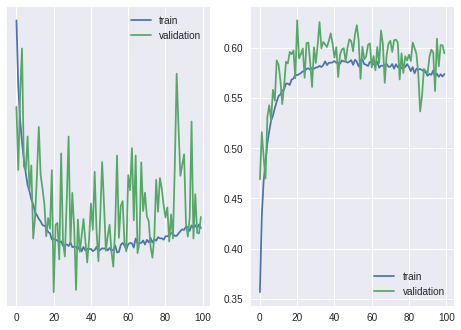

time taken:  3285.1273350715637


In [53]:

model_mp_decay = Sequential()

model_mp_decay.add(Conv2D(64, (3,3), padding='same', input_shape=x_train.shape[1:]))
model_mp_decay.add(Activation('relu'))
model_mp_decay.add(MaxPooling2D(pool_size=(2,2)))

model_mp_decay.add(Conv2D(64, (3,3), padding='same'))
model_mp_decay.add(Activation('relu'))
model_mp_decay.add(MaxPooling2D(pool_size=(2,2)))
     
model_mp_decay.add(Flatten())
model_mp_decay.add(Dense(num_classes, activation='softmax'))

batch_size = 64
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model_mp_decay.compile(loss='categorical_crossentropy', optimizer=opt_rms, 
                 metrics=['accuracy'])

start = time.time()
history_mp_decay = model_mp_decay.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=100,
                    verbose=1,
                    validation_data=(x_test,y_test),
                    callbacks=[plot])
end = time.time()
print('time taken: ',end-start)

In [0]:
model_mp_decay.save('CIFAR-10_2layer_CNN_LR_decay.h5')

In [0]:
with open('CIFAR-10_2layer_CNN_LR_decay-history', 'wb') as file_pi:
  pickle.dump(history_mp_decay.history, file_pi, protocol=pickle.HIGHEST_PROTOCOL)

### Using Learning rate scheduler

In [0]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 40:
        lrate = 0.0005
    if epoch > 70:
        lrate = 0.0001
    return lrate 

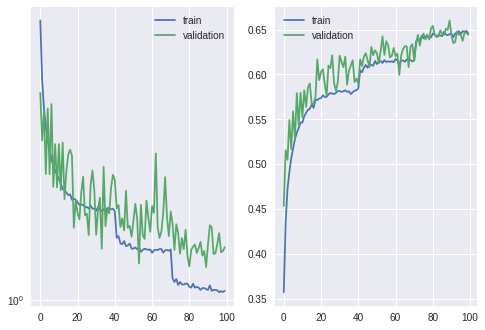

time taken:  3291.4586522579193


In [80]:
model_mp_lr_sched = Sequential()

model_mp_lr_sched.add(Conv2D(64, (3,3), padding='same', input_shape=x_train.shape[1:]))
model_mp_lr_sched.add(Activation('relu'))
#model_mp_lr_sched.add(BatchNormalization())
model_mp_lr_sched.add(MaxPooling2D(pool_size=(2,2)))

model_mp_lr_sched.add(Conv2D(64, (3,3), padding='same'))
model_mp_lr_sched.add(Activation('relu'))
#model_mp_lr_sched.add(BatchNormalization())
model_mp_lr_sched.add(MaxPooling2D(pool_size=(2,2)))

model_mp_lr_sched.add(Flatten())
model_mp_lr_sched.add(Dense(num_classes, activation='softmax'))

batch_size = 64
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=0.0)
model_mp_lr_sched.compile(loss='categorical_crossentropy', optimizer=opt_rms, 
                 metrics=['accuracy'])

start = time.time()
history_mp_lr_sched = model_mp_lr_sched.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=100,
                    verbose=1,
                    validation_data=(x_test,y_test),
                    callbacks=[LearningRateScheduler(lr_schedule),plot])
end = time.time()
print('time taken: ',end-start)

In [0]:
model_mp_lr_sched.save('CIFAR-10_2layer_CNN_LR_sched.h5')

In [0]:
with open('CIFAR-10_2layer_CNN_LR_sched-history', 'wb') as file_pi:
  pickle.dump(history_mp_lr_sched.history, file_pi, protocol=pickle.HIGHEST_PROTOCOL)

Why the steps? see carefully.

### Using L2 regularization

Why L2 only for CONV2D layer?

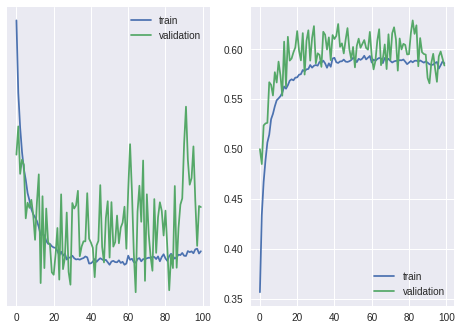

time taken:  3287.630215406418


In [58]:
L2weight = 1e-4

model_mp_decay_L2 = Sequential()

model_mp_decay_L2.add(Conv2D(64, (3,3), padding='same',kernel_regularizer=regularizers.l2(L2weight),input_shape=x_train.shape[1:]))
model_mp_decay_L2.add(Activation('relu'))
model_mp_decay_L2.add(MaxPooling2D(pool_size=(2,2)))

model_mp_decay_L2.add(Conv2D(64, (3,3), padding='same',kernel_regularizer=regularizers.l2(L2weight)))
model_mp_decay_L2.add(Activation('relu'))
model_mp_decay_L2.add(MaxPooling2D(pool_size=(2,2)))
     
model_mp_decay_L2.add(Flatten())
model_mp_decay_L2.add(Dense(num_classes, activation='softmax'))


batch_size = 64
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model_mp_decay_L2.compile(loss='categorical_crossentropy', optimizer=opt_rms, 
                 metrics=['accuracy'])

start = time.time()
history_mp_decay_L2 = model_mp_decay_L2.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=100,
                    verbose=1,
                    validation_data=(x_test,y_test),
                    callbacks=[plot])
end = time.time()
print('time taken: ',end-start)


In [0]:
model_mp_decay_L2.save('CIFAR-10_2layer_CNN_LR_decay_L2_regularization.h5')

In [0]:
with open('CIFAR-10_2layer_CNN_LR_decay_L2_regularization-history', 'wb') as file_pi:
  pickle.dump(history_mp_decay_L2.history, file_pi, protocol=pickle.HIGHEST_PROTOCOL)

### Using Dropout Regularization

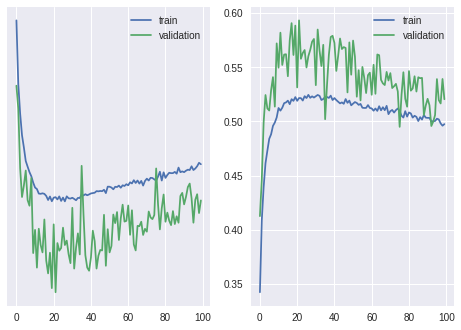

time taken:  3328.0302567481995


In [63]:
model_mp_decay_DR = Sequential()

model_mp_decay_DR.add(Conv2D(64, (3,3), padding='same', input_shape=x_train.shape[1:]))
model_mp_decay_DR.add(Activation('relu'))
model_mp_decay_DR.add(MaxPooling2D(pool_size=(2,2)))
model_mp_decay_DR.add(Dropout(0.3))

model_mp_decay_DR.add(Conv2D(64, (3,3), padding='same'))
model_mp_decay_DR.add(Activation('relu'))
model_mp_decay_DR.add(MaxPooling2D(pool_size=(2,2)))
model_mp_decay_DR.add(Dropout(0.3))

model_mp_decay_DR.add(Flatten())
model_mp_decay_DR.add(Dense(num_classes, activation='softmax'))

batch_size = 64
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model_mp_decay_DR.compile(loss='categorical_crossentropy', optimizer=opt_rms, 
                 metrics=['accuracy'])

start = time.time()
history_mp_decay_DR = model_mp_decay_DR.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=100,
                    verbose=1,
                    validation_data=(x_test,y_test),
                    callbacks=[plot])
end = time.time()
print('time taken: ',end-start)

In [0]:
model_mp_decay_DR.save('CIFAR-10_2layer_CNN_LR_decay_DROPOUT_regularization.h5')

In [0]:
with open('CIFAR-10_2layer_CNN_LR_decay_DROPOUT_regularization-history', 'wb') as file_pi:
  pickle.dump(history_mp_decay_DR.history, file_pi, protocol=pickle.HIGHEST_PROTOCOL)

### Using Batch Normalization

Where do we need to put batch normalization layers?

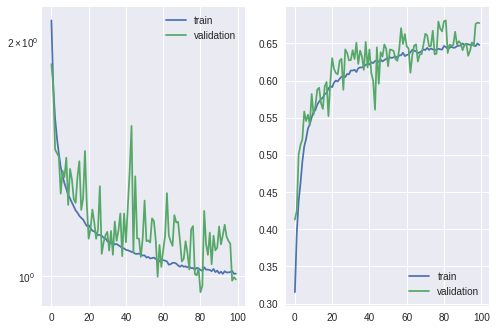

time taken:  3409.4101469516754


In [65]:
model_mp_decay_BN = Sequential()

model_mp_decay_BN.add(Conv2D(64, (3,3), padding='same', input_shape=x_train.shape[1:]))
model_mp_decay_BN.add(Activation('relu'))
model_mp_decay_BN.add(BatchNormalization())
model_mp_decay_BN.add(MaxPooling2D(pool_size=(2,2)))

model_mp_decay_BN.add(Conv2D(64, (3,3), padding='same'))
model_mp_decay_BN.add(Activation('relu'))
model_mp_decay_BN.add(BatchNormalization())
model_mp_decay_BN.add(MaxPooling2D(pool_size=(2,2)))

model_mp_decay_BN.add(Flatten())
model_mp_decay_BN.add(Dense(num_classes, activation='softmax'))

batch_size = 64
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model_mp_decay_BN.compile(loss='categorical_crossentropy', optimizer=opt_rms, 
                 metrics=['accuracy'])

start = time.time()
history_mp_decay_BN = model_mp_decay_BN.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=100,
                    verbose=1,
                    validation_data=(x_test,y_test),
                    callbacks=[plot])
end = time.time()
print('time taken: ',end-start)

In [0]:
model_mp_decay_BN.save('CIFAR-10_2layer_CNN_LR_decay_BATCH_Normalization.h5')

In [0]:
with open('CIFAR-10_2layer_CNN_LR_decay_BATCH_Normalization-history', 'wb') as file_pi:
  pickle.dump(history_mp_decay_BN.history, file_pi, protocol=pickle.HIGHEST_PROTOCOL)

### Using L2, Dropout

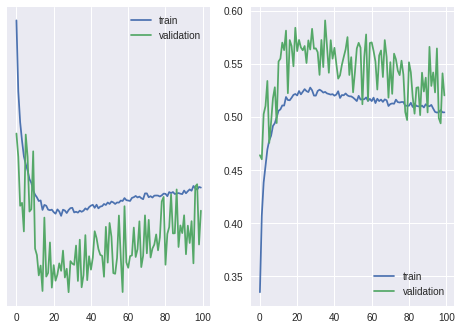

time taken:  3347.6359627246857


In [76]:
L2weight = 1e-4

model_mp_decay_L2_DR = Sequential()

model_mp_decay_L2_DR.add(Conv2D(64, (3,3), padding='same',kernel_regularizer=regularizers.l2(L2weight),input_shape=x_train.shape[1:]))
model_mp_decay_L2_DR.add(Activation('relu'))
model_mp_decay_L2_DR.add(MaxPooling2D(pool_size=(2,2)))
model_mp_decay_L2_DR.add(Dropout(0.3))

model_mp_decay_L2_DR.add(Conv2D(64, (3,3), padding='same',kernel_regularizer=regularizers.l2(L2weight)))
model_mp_decay_L2_DR.add(Activation('relu'))
model_mp_decay_L2_DR.add(MaxPooling2D(pool_size=(2,2)))
model_mp_decay_L2_DR.add(Dropout(0.3))
  
model_mp_decay_L2_DR.add(Flatten())
model_mp_decay_L2_DR.add(Dense(num_classes, activation='softmax'))


batch_size = 64
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model_mp_decay_L2_DR.compile(loss='categorical_crossentropy', optimizer=opt_rms, 
                 metrics=['accuracy'])

start = time.time()
history_mp_decay_L2_DR = model_mp_decay_L2_DR.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=100,
                    verbose=1,
                    validation_data=(x_test,y_test),
                    callbacks=[plot])
end = time.time()
print('time taken: ',end-start)

In [0]:
model_mp_decay_L2_DR.save('CIFAR-10_2layer_CNN_LR_decay_L2_DROPOUT.h5')

In [0]:
with open('CIFAR-10_2layer_CNN_LR_decay_L2_DROPOUT-history', 'wb') as file_pi:
  pickle.dump(history_mp_decay_L2_DR.history, file_pi, protocol=pickle.HIGHEST_PROTOCOL)

### Using L2, Dropout and Batch normalization

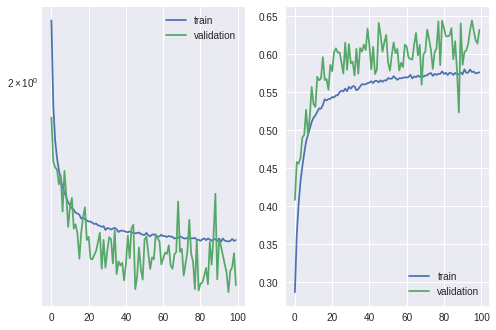

time taken:  3523.090801715851


In [114]:
L2weight = 1e-4

model_mp_decay_L2_DR_BN = Sequential()

model_mp_decay_L2_DR_BN.add(Conv2D(64, (3,3), padding='same',kernel_regularizer=regularizers.l2(L2weight),input_shape=x_train.shape[1:]))
model_mp_decay_L2_DR_BN.add(Activation('relu'))
model_mp_decay_L2_DR_BN.add(BatchNormalization())
model_mp_decay_L2_DR_BN.add(MaxPooling2D(pool_size=(2,2)))
model_mp_decay_L2_DR_BN.add(Dropout(0.3))

model_mp_decay_L2_DR_BN.add(Conv2D(64, (3,3), padding='same',kernel_regularizer=regularizers.l2(L2weight)))
model_mp_decay_L2_DR_BN.add(Activation('relu'))
model_mp_decay_L2_DR_BN.add(BatchNormalization())
model_mp_decay_L2_DR_BN.add(MaxPooling2D(pool_size=(2,2)))
model_mp_decay_L2_DR_BN.add(Dropout(0.3))
  
model_mp_decay_L2_DR_BN.add(Flatten())
model_mp_decay_L2_DR_BN.add(Dense(num_classes, activation='softmax'))


batch_size = 64
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model_mp_decay_L2_DR_BN.compile(loss='categorical_crossentropy', optimizer=opt_rms, 
                 metrics=['accuracy'])

start = time.time()
history_mp_decay_L2_DR_BN = model_mp_decay_L2_DR_BN.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=100,
                    verbose=1,
                    validation_data=(x_test,y_test),
                    callbacks=[plot])
end = time.time()
print('time taken: ',end-start)

In [0]:
model_mp_decay_L2_DR_BN.save('CIFAR-10_2layer_CNN_LR_decay_L2_DROPOUT_BN.h5')

In [0]:
with open('CIFAR-10_2layer_CNN_LR_decay_L2_DROPOUT_BN-history', 'wb') as file_pi:
  pickle.dump(history_mp_decay_L2_DR_BN.history, file_pi)

### Comparison of various models

#### Time taken 

*   Basic : 3258 secs
*   Basic new run : 3272 secs
*   Decaying Learning rate : 3285 secs
*   Scheduled Learning rate : 3291 secs
*   L2 regularization : 3287 secs
*   Dropout : 3328 secs
*   Batch Normalization : 3409 secs
*   L2 + Dropout : 3347 secs
*   L2 + Dropout + Batch Normalization : 3523 secs











In [117]:
!ls  -lrthp *-history

-rw-r--r-- 1 root root 9.4K Dec 23 23:52 CIFAR-10_2layer_CNN_LR_sched-history
-rw-r--r-- 1 root root 7.6K Dec 23 23:56 CIFAR-10_2layer_CNN-history
-rw-r--r-- 1 root root 7.6K Dec 23 23:56 CIFAR-10_2layer_CNN_different_run-history
-rw-r--r-- 1 root root 7.6K Dec 23 23:56 CIFAR-10_2layer_CNN_LR_decay-history
-rw-r--r-- 1 root root 7.6K Dec 23 23:57 CIFAR-10_2layer_CNN_LR_decay_L2_regularization-history
-rw-r--r-- 1 root root 7.6K Dec 23 23:57 CIFAR-10_2layer_CNN_LR_decay_DROPOUT_regularization-history
-rw-r--r-- 1 root root 7.6K Dec 23 23:57 CIFAR-10_2layer_CNN_LR_decay_BATCH_Normalization-history
-rw-r--r-- 1 root root 7.6K Dec 23 23:57 CIFAR-10_2layer_CNN_LR_decay_L2_DROPOUT-history
-rw-r--r-- 1 root root  12K Dec 24 01:07 CIFAR-10_2layer_CNN_LR_decay_L2_DROPOUT_BN-history


#### Plots

In [0]:
#print(history_mp.history.keys())
#OUTPUT: dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
#with callbacks=[LearningRateScheduler], lr will also be dictionary key

histkeys = ['val_loss', 'val_acc', 'loss', 'acc']

filnames = ['CIFAR-10_2layer_CNN-history',
            'CIFAR-10_2layer_CNN_different_run-history',
            'CIFAR-10_2layer_CNN_LR_decay-history',
            'CIFAR-10_2layer_CNN_LR_sched-history',
            'CIFAR-10_2layer_CNN_LR_decay_L2_regularization-history',
            'CIFAR-10_2layer_CNN_LR_decay_DROPOUT_regularization-history',
            'CIFAR-10_2layer_CNN_LR_decay_BATCH_Normalization-history',
            'CIFAR-10_2layer_CNN_LR_decay_L2_DROPOUT-history',
            'CIFAR-10_2layer_CNN_LR_decay_L2_DROPOUT_BN-history']

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


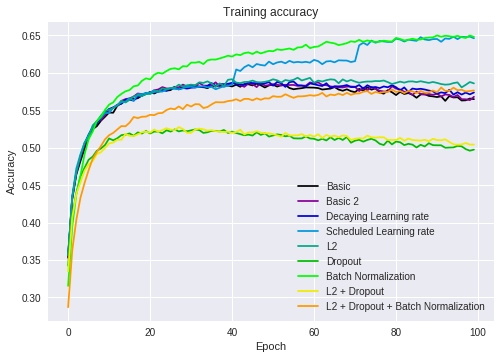

In [152]:
colormap = plt.cm.spectral
#colormap = plt.cm.Paired
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(filnames)+1)])

for i in range(len(filnames)):
  with open(filnames[i],'rb') as f:  # Python 3: open(..., 'rb')
    temp = pickle.load(f)
  plt.plot(temp['acc'])
  
plt.title('Training accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Basic', 'Basic 2', 'Decaying Learning rate', 'Scheduled Learning rate',
            'L2','Dropout','Batch Normalization',
            'L2 + Dropout','L2 + Dropout + Batch Normalization'], loc='lower right')
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


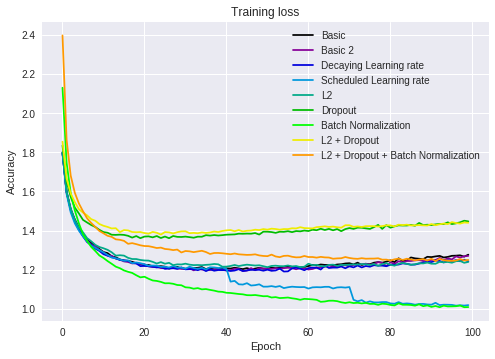

In [148]:
colormap = plt.cm.spectral
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(filnames)+1)])

for i in range(len(filnames)):
  with open(filnames[i],'rb') as f:  # Python 3: open(..., 'rb')
    temp = pickle.load(f)
  plt.plot(temp['loss'])
  
plt.title('Training loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Basic', 'Basic 2', 'Decaying Learning rate', 'Scheduled Learning rate',
            'L2','Dropout','Batch Normalization',
            'L2 + Dropout','L2 + Dropout + Batch Normalization'], loc='upper right')
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


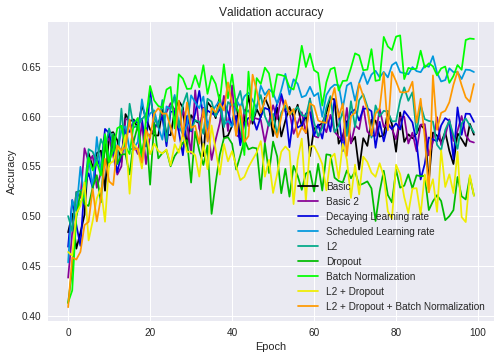

In [149]:
colormap = plt.cm.spectral
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(filnames)+1)])

for i in range(len(filnames)):
  with open(filnames[i],'rb') as f:  # Python 3: open(..., 'rb')
    temp = pickle.load(f)
  plt.plot(temp['val_acc'])
  
plt.title('Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Basic', 'Basic 2', 'Decaying Learning rate', 'Scheduled Learning rate',
            'L2','Dropout','Batch Normalization',
            'L2 + Dropout','L2 + Dropout + Batch Normalization'], loc='lower right')
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


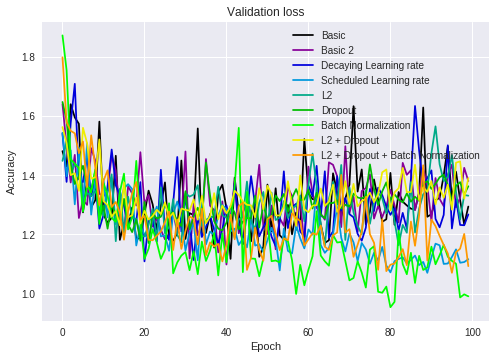

In [150]:
colormap = plt.cm.spectral
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(filnames)+1)])

for i in range(len(filnames)):
  with open(filnames[i],'rb') as f:  # Python 3: open(..., 'rb')
    temp = pickle.load(f)
  plt.plot(temp['val_loss'])
  
plt.title('Validation loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Basic', 'Basic 2', 'Decaying Learning rate', 'Scheduled Learning rate',
            'L2','Dropout','Batch Normalization',
            'L2 + Dropout','L2 + Dropout + Batch Normalization'], loc='upper right')
plt.show()

### Extras

In [7]:
model = Sequential()

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(L2weight), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(L2weight)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(L2weight)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))


model.add(Conv2D(128, (3,3), padding='same',kernel_regularizer=regularizers.l2(L2weight)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
 
    
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
 
model.summary()

NameError: ignored

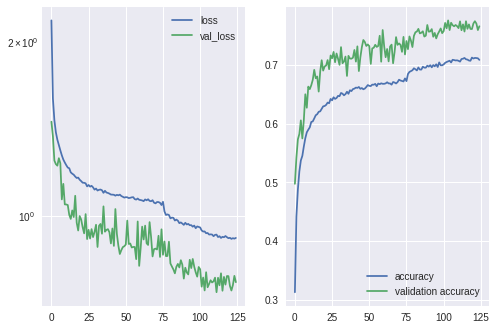

In [0]:
from livelossplot import PlotLossesKeras
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=125,
                    verbose=1,
                    validation_data=(x_test,y_test),
                    callbacks=[LearningRateScheduler(lr_schedule),plot])



1.   Using dropout and L2 along with Batch normalization worsens the models.
2.   Why is training loss larger than validation loss. Underfitting?
3. Keras batch normalization slower?

